In [1]:
import scipy
import numpy as np
import random
import uncertainties
from uncertainties import ufloat
import pandas as pd
import matplotlib.pyplot as plt
from constants import *

In [2]:
def dur_tot_calc(p, b, ror, rho, e=0., w=0.):
    '''
    Solves for total duration T14 (in days)
    From Winn 2010, Eq 14 with eccentricity consideration from Eq 16
    Approximations used: sin(i) ~ 1, arcsin(x) ~ x
    Args:
        p: period (days)
        b: impact parameter
        rho: stellar density or circular stellar density (g/cc)
        e: eccenticity - if true stellar density is input; default 0
        w: omega, argument of periastron (radians) - if true stellar density is input; default 0
        ror: Rp/Rs
    Returns:
        T14: total transit duration 1->4 (in days)
    '''
    p *= day
    aor = ((p**2 * G * rho) / (3 * np.pi))**(1/3)
    f_ew = ((1-e**2)**(1/2)/(1+e*np.sin(w)))
    dur_tot = p/np.pi * aor**(-1) * ((1+ror)**2 - b**2)**(1/2) * f_ew
    return dur_tot/day

# Select baseline system parameters

In [3]:
per_inj = 5.
t0_inj = 0.

ror_inj = 0.05
b_inj = 0.3

e_inj = 0.1
w_inj = np.pi/2.

rho_test = rhosun
rho_test_err = rhosun*0.1

T14_inj = dur_tot_calc(per_inj, b_inj, ror_inj, rho_test, e_inj, w_inj)

params = {'period': per_inj,
         't0': t0_inj,
         'dur': T14_inj,
         'ror': ror_inj,
         'b': b_inj,
         'e': e_inj,
         'omega': w_inj,
         'rho_star': rho_test}

params

{'period': 5.0,
 't0': 0.0,
 'dur': 0.1177221267616729,
 'ror': 0.05,
 'b': 0.3,
 'e': 0.1,
 'omega': 1.5707963267948966,
 'rho_star': 1.409779824307527}

# Sample from uniform distributions and calculate likelihood assuming 10% uncertainty on $T_{14}$ and $r_p/R_s$

In [4]:
N = int(1e6)

# draw rho, ror, b
rhocirc_uni = np.random.uniform(rhosun/10, rhosun*10, N)
ror_uni = np.random.uniform(0.001, 0.2, N)
b_uni = np.array([np.random.uniform(0, 1+ror, 1)[0] for ror in ror_uni])

# period is fixed --> get derived total duration (T14)
T14_uni = dur_tot_calc(per_inj, b_uni, ror_uni, rhocirc_uni)

# set assumed 10% errors or
sig_T14 = T14_inj * 0.1
sig_ror = ror_inj * 0.1

# calculate chi-squared for T14 and ror
chi2_T14 = ((T14_uni - T14_inj) / sig_T14)**2
chi2_ror = ((ror_uni - ror_inj) / sig_ror)**2

# calculate log-likelihood
logL = -0.5*chi2_T14 - 0.5*chi2_ror

# weight posterior samples by log-likelihood
w = np.exp(logL)
w /= np.sum(w)

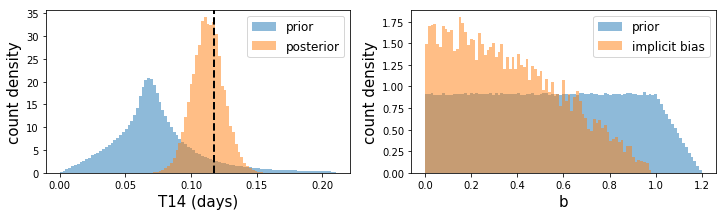

In [5]:
# plot prior distribution vs. posterior distribution
fig, ax = plt.subplots(1,2, figsize=(12,3))

bins = np.linspace(0,np.percentile(T14_uni,99),99)

ax[0].hist(T14_uni, bins=bins, density=True, label='prior', alpha=0.5)
ax[0].hist(T14_uni, weights=w, bins=bins, density=True, label='posterior', alpha=0.5)
ax[0].axvline(T14_inj, ls="--", lw=2, color="k")
ax[0].legend(fontsize=12)
ax[0].set_ylabel('count density', fontsize=15)
ax[0].set_xlabel('T14 (days)', fontsize=15)

ax[1].hist(b_uni, bins=99, density=True, label='prior', alpha=0.5)
ax[1].hist(b_uni, weights=w, bins=99, density=True, label='implicit bias', alpha=0.5)
ax[1].legend(fontsize=12)
ax[1].set_ylabel('count density', fontsize=15)
ax[1].set_xlabel('b', fontsize=15)

plt.show()

# Changing the range of $\rho_{\rm circ}$ changes the prior on $T_{14}$

Here, the upper (lower) bound of $\rho_{\rm circ}$ is changed from 10 (0.1) g/cc to 50 (0.02) g/cc  -- it is possible to attain such high $\rho_{\rm circ}$ values for highly eccentric orbits

In [6]:
N = int(1e6)

# draw rho, ror, b
rhocirc_uni = np.random.uniform(rhosun/50, rhosun*50, N)
ror_uni = np.random.uniform(0.001, 0.2, N)
b_uni = np.array([np.random.uniform(0, 1+ror, 1)[0] for ror in ror_uni])

# period is fixed --> get derived total duration (T14)
T14_uni = dur_tot_calc(per_inj, b_uni, ror_uni, rhocirc_uni)

# set assumed 10% errors or
sig_T14 = T14_inj * 0.1
sig_ror = ror_inj * 0.1

# calculate chi-squared for T14 and ror
chi2_T14 = ((T14_uni - T14_inj) / sig_T14)**2
chi2_ror = ((ror_uni - ror_inj) / sig_ror)**2

# calculate log-likelihood
logL = -0.5*chi2_T14 - 0.5*chi2_ror

# weight posterior samples by log-likelihood
w = np.exp(logL)
w /= np.sum(w)

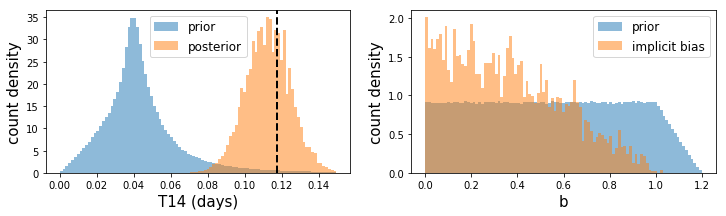

In [7]:
# plot prior distribution vs. posterior distribution
fig, ax = plt.subplots(1,2, figsize=(12,3))

bins = np.linspace(0,np.percentile(T14_uni,99),99)

ax[0].hist(T14_uni, bins=bins, density=True, label='prior', alpha=0.5)
ax[0].hist(T14_uni, weights=w, bins=bins, density=True, label='posterior', alpha=0.5)
ax[0].axvline(T14_inj, ls="--", lw=2, color="k")
ax[0].legend(fontsize=12)
ax[0].set_ylabel('count density', fontsize=15)
ax[0].set_xlabel('T14 (days)', fontsize=15)
#ax[0].set_xlim(np.percentile(T14_uni,0.3),np.percentile(T14_uni,99.7))

ax[1].hist(b_uni, bins=99, density=True, label='prior', alpha=0.5)
ax[1].hist(b_uni, weights=w, bins=99, density=True, label='implicit bias', alpha=0.5)
ax[1].legend(fontsize=12)
ax[1].set_ylabel('count density', fontsize=15)
ax[1].set_xlabel('b', fontsize=15)

plt.show()

So, a uniform prior on $\rho_{\rm circ}$ induces a strong prior on $T_{14}$ which is dependent on the $\rho_{\rm circ}$ interval bounds.

# Can we do better sampling directly in $T_{14}$?

In [8]:
N = int(1e6)

# now draw from T14, ror, b
T14_uni = np.random.uniform(0.01, 0.3, N)
ror_uni = np.random.uniform(0.001, 0.2, N)
b_uni = np.array([np.random.uniform(0, 1+ror, 1)[0] for ror in ror_uni])

# set assumed 10% errors or
sig_T14 = T14_inj * 0.1
sig_ror = ror_inj * 0.1

# calculate chi-squared for T14 and ror
chi2_T14 = ((T14_uni - T14_inj) / sig_T14)**2
chi2_ror = ((ror_uni - ror_inj) / sig_ror)**2

# calculate log-likelihood
logL = -0.5*chi2_T14 - 0.5*chi2_ror

# weight posterior samples by log-likelihood
w = np.exp(logL)
w /= np.sum(w)

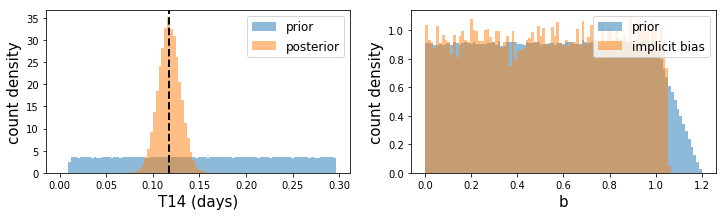

In [9]:
# plot prior distribution vs. posterior distribution
fig, ax = plt.subplots(1,2, figsize=(12,3))

bins = np.linspace(0,np.percentile(T14_uni,99),99)

ax[0].hist(T14_uni, bins=bins, density=True, label='prior', alpha=0.5)
ax[0].hist(T14_uni, weights=w, bins=bins, density=True, label='posterior', alpha=0.5)
ax[0].axvline(T14_inj, ls="--", lw=2, color="k")
ax[0].legend(fontsize=12)
ax[0].set_ylabel('count density', fontsize=15)
ax[0].set_xlabel('T14 (days)', fontsize=15)

ax[1].hist(b_uni, bins=99, density=True, label='prior', alpha=0.5)
ax[1].hist(b_uni, weights=w, bins=99, density=True, label='implicit bias', alpha=0.5)
ax[1].legend(fontsize=12)
ax[1].set_ylabel('count density', fontsize=15)
ax[1].set_xlabel('b', fontsize=15)

plt.show()